https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia 
x-ray data 폐렴 구분 AI 모델
2.2 : NOMAL, PNEUMONIA 2진분류 => NOMAL, VIRAL PNEUMONIA, VACTERIAL PNEUMONIA

In [37]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf 
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9832413935389216415
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4922667008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18385831808683275329
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


'2.4.1'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, schedules


import pandas as pd
import seaborn as sns
import numpy as np


In [3]:
train_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/train'
validation_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/val'
test_data_dir = 'C:/Users/s_wnsgk4041/data/2.2/test'

nb_train_samples = len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/NORMAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/VIRAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/train/BACTERIAL/'))
nb_validation_samples = len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/NORMAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/VIRAL/')) + len(os.listdir('C:/Users/s_wnsgk4041/data/2.2/val/BACTERIAL/'))
print(nb_train_samples)
print(nb_validation_samples)

4762
475


In [14]:
img_width = 125
img_height = 150
img_channel = 3

In [15]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_height, img_width, img_channel))

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [17]:
from tensorflow.keras.losses import CategoricalCrossentropy
losses = CategoricalCrossentropy(label_smoothing=0.1)

In [18]:
from tensorflow.keras.optimizers import Adam
import six
import copy
from six.moves import zip
from tensorflow.keras import backend as K

class AdamW(Adam):
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4,  # decoupled weight decay (1/6)
                 epsilon=1e-8, decay=0., **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.init_lr = lr # decoupled weight decay (2/6)
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (3/6)
        self.epsilon = epsilon
        self.initial_decay = decay

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd # decoupled weight decay (4/6)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        eta_t = lr / self.init_lr # decoupled weight decay (5/6)

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - eta_t * wd * p # decoupled weight decay (6/6)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

adamw= AdamW(lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4, epsilon=1e-8, decay=0.)

In [19]:
model.compile(
    loss=losses,
    optimizer= adamw,
    metrics=['accuracy']
)

In [20]:
epochs = 200
batch_size = 32

In [21]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

test_datagen = ImageDataGenerator(rescale = 1./255,)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4761 images belonging to 3 classes.
Found 474 images belonging to 3 classes.
Found 621 images belonging to 3 classes.


In [22]:
print(len(train_generator.classes[train_generator.classes[:] == 0]))
count_class0 = len(train_generator.classes[train_generator.classes[:] == 0])
print(len(train_generator.classes[train_generator.classes[:] == 1]))
count_class1 = len(train_generator.classes[train_generator.classes[:] == 1])
print(len(train_generator.classes[train_generator.classes[:] == 2]))
count_class2 = len(train_generator.classes[train_generator.classes[:] == 2])
count_total = count_class0 + count_class1 + count_class2
print(count_total)
count_class = 3
print(count_class)

weight_for_0 = (1 / count_class0)*(count_total)/count_class
weight_for_1 = (1 / count_class1)*(count_total)/count_class
weight_for_2 = (1 / count_class2)*(count_total)/count_class

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

2363
1201
1197
4761
3
Weight for class 0: 0.67
Weight for class 1: 1.32
Weight for class 2: 1.33


In [32]:
import tensorflow as tf
import tensorflow.keras.backend as K
import math

class CosineAnnealingWarmup(tf.keras.callbacks.Callback):
    def __init__(self, epochs_per_cycle,iteration, max_lr, min_lr, verbose = 1):
        self.epochs_per_cycle = epochs_per_cycle
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.iteration = iteration;
        self.steps = 0;
        self.learning_rate = max_lr;
        self.epochs = 0; # epoch to search min_lr for each iteration 
        self.warmup_epoch = 10  # warmup epcch
        self.verbose = verbose # log
        self.lrates = list() # for graph
        
        
    def cosine_annealing(self, epoch, epochs_per_cycle, max_lr):
        self.epochs += 1; 
        cos_inner = (math.pi * (self.epochs % epochs_per_cycle)) / (epochs_per_cycle)
        self.learning_rate = max_lr/2 * (math.cos(cos_inner) + 1)
        
        if ((self.epochs % epochs_per_cycle) == (epochs_per_cycle-1)):
            self.steps += 1
            self.max_lr *= 0.8
            self.epochs = 0;
            self.epochs_per_cycle = math.floor(self.epochs_per_cycle*1.2)
            
        return max_lr/2 * (math.cos(cos_inner) + 1)
  
    def warm_up(self, epoch):
        
        self.learning_rate = self.max_lr * epoch / self.warmup_epoch
        
        return self.learning_rate

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs = None):
        if (epoch < self.warmup_epoch):
            # warm up learning rate
            lr = self.warm_up(epoch)
       
        elif(self.steps < self.iteration):
            # calculate learning rate
            lr = self.cosine_annealing(epoch, self.epochs_per_cycle, self.max_lr)
            
        else:
            lr = self.min_lr
        
        if (self.verbose == 1):
            print('\nEpoch %05d: CosineAnnealingScheduler setting learng rate to %s.' % (epoch + 1, lr))  

        
        K.set_value(self.model.optimizer.lr, lr)

        self.lrates.append(lr)

In [34]:
cosine_schedule = CosineAnnealingWarmup(epochs_per_cycle=50, iteration=3, max_lr = 1e-3, min_lr = 1e-6)

# for i in range(1, 200 + 1):
#     cosine_schedule.on_epoch_begin(i)
    
# import matplotlib.pyplot as plt

# plt.plot(cosine_schedule.lrates)
# plt.title('Cosine Annealing_Toy')
# plt.xlabel('epochs'); plt.ylabel('learning_rate')
# plt.grid()
# plt.show()

In [35]:
model_folder = 'C:/Users/s_wnsgk4041/cal/2-2_inceptionV3/'
model_path = model_folder + '{epoch:02d}-{val_loss:.4f}.hdf5'


check_point = ModelCheckpoint(model_path, monitor = 'val_accuracy', save_best_only=False)
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=200, restore_best_weights=True)

In [36]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks = [check_point,early_stopping, cosine_schedule],
    class_weight=class_weight
)

C:\Users\s_wnsgk4041\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200

Epoch 00001: CosineAnnealingScheduler setting learng rate to 0.0.
148/148 [==============================] - 87s 502ms/step - loss: 1.7803 - accuracy: 0.3323 - val_loss: 1.3578 - val_accuracy: 0.3237
Epoch 2/200

Epoch 00002: CosineAnnealingScheduler setting learng rate to 0.0001.
148/148 [==============================] - 67s 449ms/step - loss: 1.5000 - accuracy: 0.4151 - val_loss: 1.0281 - val_accuracy: 0.5826
Epoch 3/200

Epoch 00003: CosineAnnealingScheduler setting learng rate to 0.0002.
148/148 [==============================] - 65s 441ms/step - loss: 1.0467 - accuracy: 0.6057 - val_loss: 1.2293 - val_accuracy: 0.6652
Epoch 4/200

Epoch 00004: CosineAnnealingScheduler setting learng rate to 0.00030000000000000003.
148/148 [==============================] - 66s 447ms/step - loss: 0.9582 - accuracy: 0.6181 - val_loss: 0.8503 - val_accuracy: 0.7344
Epoch 5/200

Epoch 00005: CosineAnnealingScheduler setting learng rate to 0.0004.
148/148 [==============================] 

Epoch 37/200

Epoch 00037: CosineAnnealingScheduler setting learng rate to 0.00043733338321784795.
148/148 [==============================] - 63s 425ms/step - loss: 0.3822 - accuracy: 0.9570 - val_loss: 0.6415 - val_accuracy: 0.8170
Epoch 38/200

Epoch 00038: CosineAnnealingScheduler setting learng rate to 0.0004063093427071377.
148/148 [==============================] - 63s 428ms/step - loss: 0.3682 - accuracy: 0.9680 - val_loss: 0.6024 - val_accuracy: 0.8438
Epoch 39/200

Epoch 00039: CosineAnnealingScheduler setting learng rate to 0.00037565505641757257.
148/148 [==============================] - 64s 433ms/step - loss: 0.3664 - accuracy: 0.9615 - val_loss: 0.7049 - val_accuracy: 0.7946
Epoch 40/200

Epoch 00040: CosineAnnealingScheduler setting learng rate to 0.00034549150281252644.
148/148 [==============================] - 64s 433ms/step - loss: 0.3584 - accuracy: 0.9683 - val_loss: 0.7908 - val_accuracy: 0.7812
Epoch 41/200

Epoch 00041: CosineAnnealingScheduler setting learng ra

148/148 [==============================] - 63s 426ms/step - loss: 0.4190 - accuracy: 0.9309 - val_loss: 0.6447 - val_accuracy: 0.8036
Epoch 73/200

Epoch 00073: CosineAnnealingScheduler setting learng rate to 0.0006972579301909577.
148/148 [==============================] - 63s 428ms/step - loss: 0.4174 - accuracy: 0.9320 - val_loss: 0.7034 - val_accuracy: 0.8013
Epoch 74/200

Epoch 00074: CosineAnnealingScheduler setting learng rate to 0.0006828427124746191.
148/148 [==============================] - 63s 429ms/step - loss: 0.4024 - accuracy: 0.9377 - val_loss: 0.8174 - val_accuracy: 0.7545
Epoch 75/200

Epoch 00075: CosineAnnealingScheduler setting learng rate to 0.0006676522425435433.
148/148 [==============================] - 63s 429ms/step - loss: 0.4055 - accuracy: 0.9399 - val_loss: 0.7912 - val_accuracy: 0.7299
Epoch 76/200

Epoch 00076: CosineAnnealingScheduler setting learng rate to 0.000651728156419935.
148/148 [==============================] - 64s 432ms/step - loss: 0.4114 

148/148 [==============================] - 64s 431ms/step - loss: 0.3093 - accuracy: 0.9989 - val_loss: 0.7746 - val_accuracy: 0.7946
Epoch 108/200

Epoch 00108: CosineAnnealingScheduler setting learng rate to 6.453177282183042e-05.
148/148 [==============================] - 64s 432ms/step - loss: 0.3076 - accuracy: 0.9985 - val_loss: 0.8062 - val_accuracy: 0.7879
Epoch 109/200

Epoch 00109: CosineAnnealingScheduler setting learng rate to 5.358983848622452e-05.
148/148 [==============================] - 64s 432ms/step - loss: 0.3093 - accuracy: 0.9996 - val_loss: 0.7965 - val_accuracy: 0.7924
Epoch 110/200

Epoch 00110: CosineAnnealingScheduler setting learng rate to 4.3597390324652885e-05.
148/148 [==============================] - 64s 430ms/step - loss: 0.3086 - accuracy: 0.9989 - val_loss: 0.7698 - val_accuracy: 0.7991
Epoch 111/200

Epoch 00111: CosineAnnealingScheduler setting learng rate to 3.458181694295961e-05.
148/148 [==============================] - 63s 428ms/step - loss: 0

148/148 [==============================] - 64s 433ms/step - loss: 0.3239 - accuracy: 0.9901 - val_loss: 0.7165 - val_accuracy: 0.8013
Epoch 143/200

Epoch 00143: CosineAnnealingScheduler setting learng rate to 0.0004677595562352109.
148/148 [==============================] - 64s 431ms/step - loss: 0.3218 - accuracy: 0.9901 - val_loss: 0.8480 - val_accuracy: 0.7612
Epoch 144/200

Epoch 00144: CosineAnnealingScheduler setting learng rate to 0.0004552378437570239.
148/148 [==============================] - 64s 431ms/step - loss: 0.3301 - accuracy: 0.9900 - val_loss: 0.6910 - val_accuracy: 0.8147
Epoch 145/200

Epoch 00145: CosineAnnealingScheduler setting learng rate to 0.00044245869835682876.
148/148 [==============================] - 64s 434ms/step - loss: 0.3130 - accuracy: 0.9951 - val_loss: 0.7614 - val_accuracy: 0.7902
Epoch 146/200

Epoch 00146: CosineAnnealingScheduler setting learng rate to 0.0004294464458642141.
148/148 [==============================] - 64s 433ms/step - loss: 0

148/148 [==============================] - 63s 425ms/step - loss: 0.3067 - accuracy: 0.9991 - val_loss: 0.8627 - val_accuracy: 0.7679
Epoch 178/200

Epoch 00178: CosineAnnealingScheduler setting learng rate to 4.287187078897969e-05.
148/148 [==============================] - 63s 426ms/step - loss: 0.3025 - accuracy: 0.9998 - val_loss: 0.8537 - val_accuracy: 0.7679
Epoch 179/200

Epoch 00179: CosineAnnealingScheduler setting learng rate to 3.6156533382969056e-05.
148/148 [==============================] - 63s 428ms/step - loss: 0.3077 - accuracy: 1.0000 - val_loss: 0.8693 - val_accuracy: 0.7656
Epoch 180/200

Epoch 00180: CosineAnnealingScheduler setting learng rate to 2.9981508148272022e-05.
148/148 [==============================] - 64s 429ms/step - loss: 0.3057 - accuracy: 0.9995 - val_loss: 0.8556 - val_accuracy: 0.7679
Epoch 181/200

Epoch 00181: CosineAnnealingScheduler setting learng rate to 2.4358549596388246e-05.
148/148 [==============================] - 64s 430ms/step - loss:

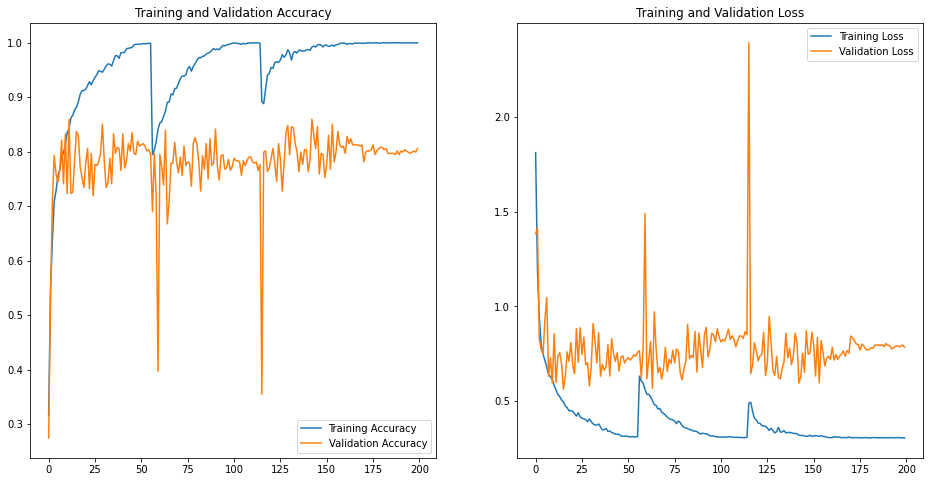

In [105]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
scores = model.evaluate_generator(test_generator)

print("\n%s: %.2f" % (model.metrics_names[0], scores[0]))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


loss: 0.61

accuracy: 85.83%
